In [1]:
import os
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import BezierCoeff, OrthoSpan, SubspaceModel


%load_ext autoreload
%autoreload 2

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=12"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%env XLA_FLAGS

jax.devices("gpu")

[cuda(id=0)]

### Load data

Data shapes: (70, 1) (70,) (33, 1) (33,)


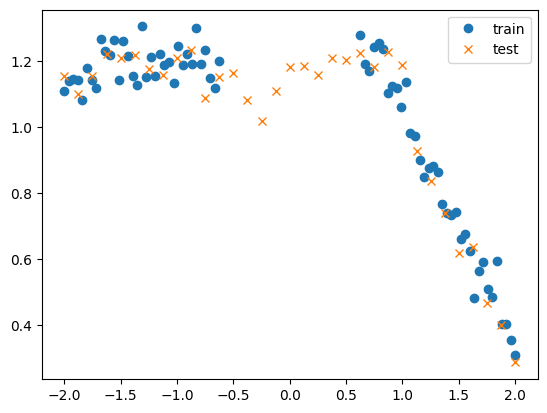

In [2]:
# load data
data = np.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test = jnp.array(data['xt'])
y_test = jnp.array(data['yt'])
plt.plot(x, y, 'o', label='train')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test.shape, y_test.shape)

## ReLU

### Define model structure

In [3]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

### Train using adam and compute expectation with 10 samples

100%|██████████| 6000/6000 [00:09<00:00, 653.79it/s] 


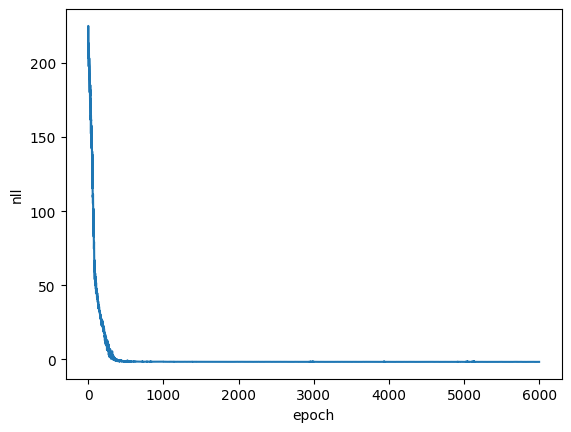

In [4]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(6000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

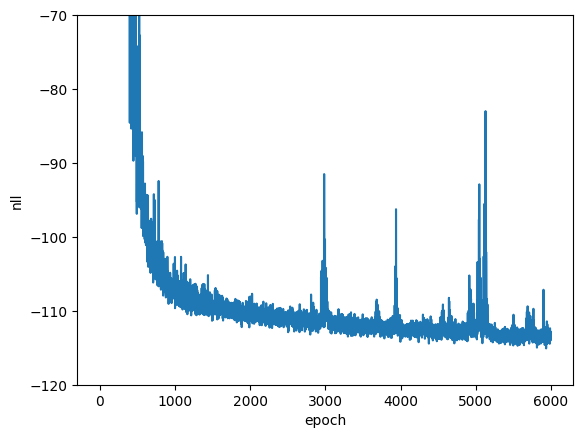

In [5]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

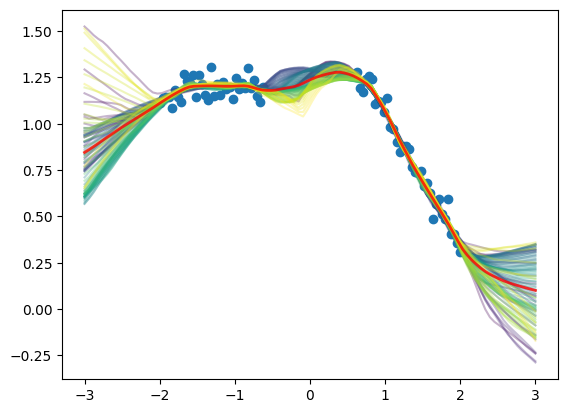

In [6]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

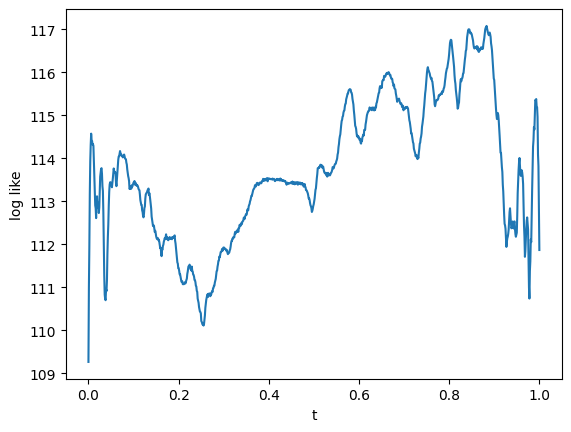

In [20]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

### plot space

In [26]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree
from src.utils import plot_subspace

#### construct subspace

In [27]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


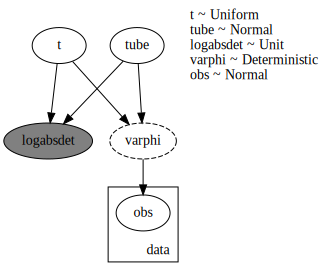

In [28]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t


def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space


generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)


@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    if t.ndim > 1:
        t = t.squeeze(-1)
    tube = l[..., 1:]/10.
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point


def model_tube(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube], axis=-1)
    if lambda_.ndim == 1:
        lambda_ = lambda_[None, :]
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    # jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    jacobian = jax.vmap(jax.jacrev(t_lambda_to_phi), in_axes=(0,))(
        lambda_).squeeze(1)  # squeeze out the output dimension
    sign, logabsdet = jax.vmap(jnp.linalg.slogdet, in_axes=(0,))(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

#### check orthogonal directions

/home/daniel/remote/bayessubspace/src/utils.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:183: 

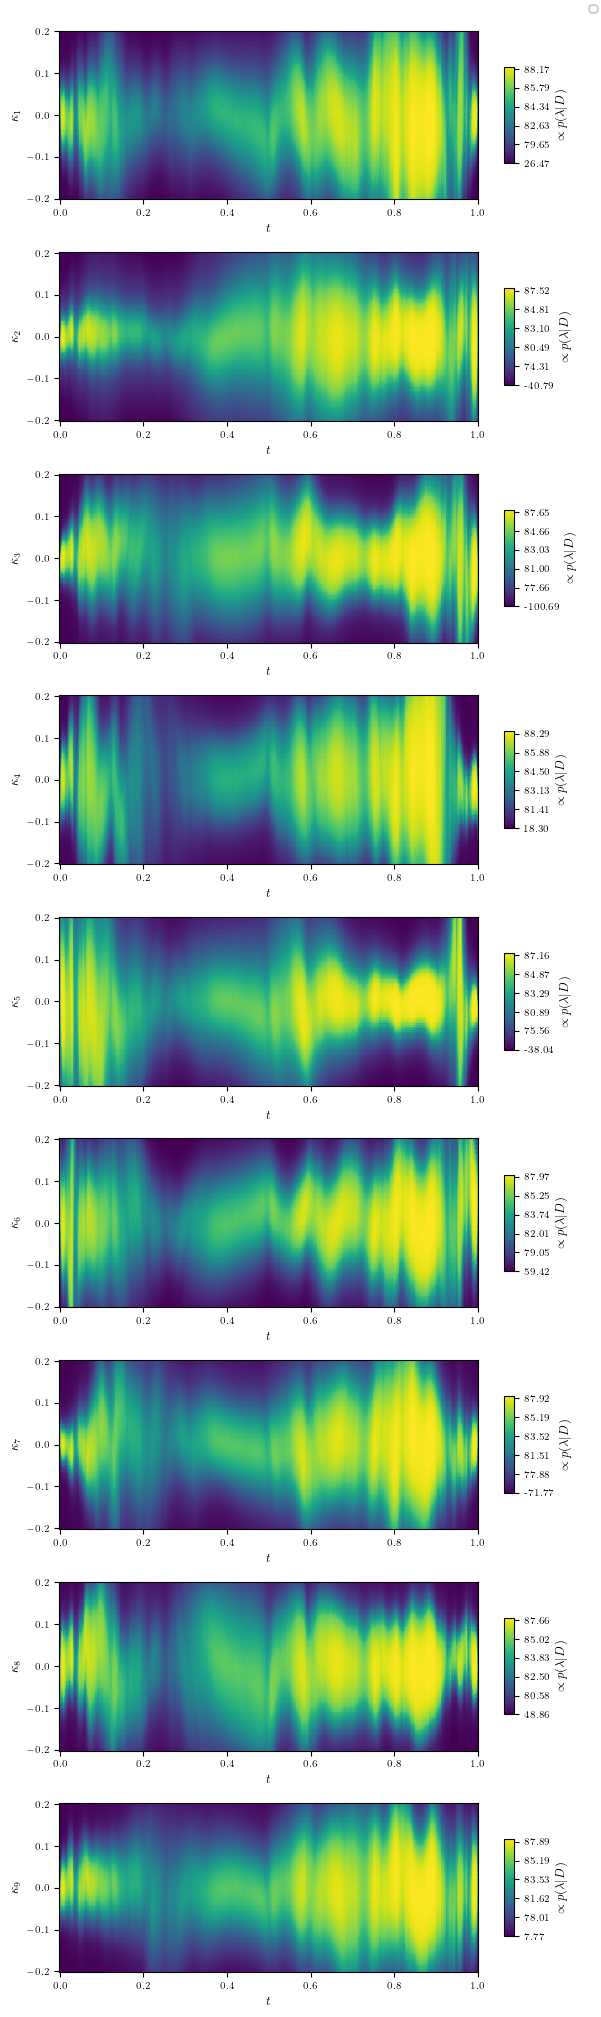

In [29]:
# Define the grid
temperature = 1.
tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.2, 0.2, 100)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()

# generate subplots over k
fig, axs = plt.subplots(k-1, 1, figsize=(6, 20))
axs = axs.ravel()
for i in range(1, k):
    t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
    t_orth_grid = t_orth_grid.at[:, i-1].set(Y.flatten())

    cml = handlers.substitute(
        model_tube, data={'t': t_grid[:, None], 'tube': t_orth_grid})
    ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                            ).get_trace(x, y, temperature)
    site = ex_trace['obs']
    log_like = (site['fn'].log_prob(site['value']) * site['scale']).sum(-1)
    site = ex_trace['logabsdet']
    logabsdet = site['fn'].log_prob(site['value'])
    site = ex_trace['t']
    prior = site['fn'].log_prob(site['value'])
    site = ex_trace['tube']
    prior += site['fn'].log_prob(site['value'])
    log_posterior = log_like + logabsdet + prior
    # log_posterior = log_like + prior

    fig = plot_subspace(X, Y, log_posterior.reshape(X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i-1])
    axs[i-1].set_ylabel(rf'$\kappa_{i}$')
    axs[i-1].set_xlabel(r'$t$')

## EeLU

### Define model structure

In [14]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

### Train using adam and compute expectation with 10 samples

100%|██████████| 6000/6000 [00:03<00:00, 1652.95it/s]


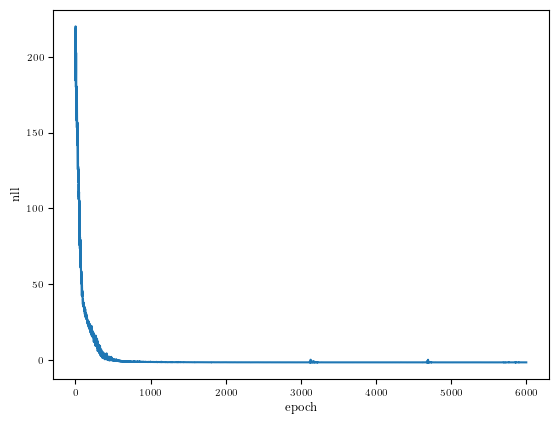

In [15]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(6000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

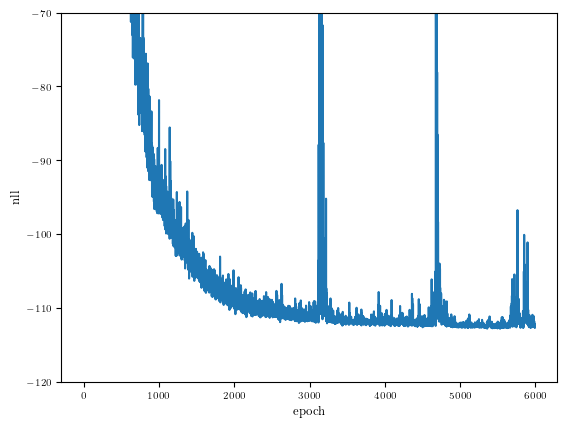

In [16]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

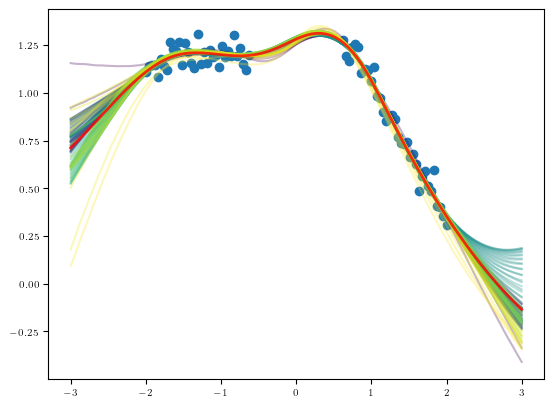

In [17]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

(110.0, 114.0)

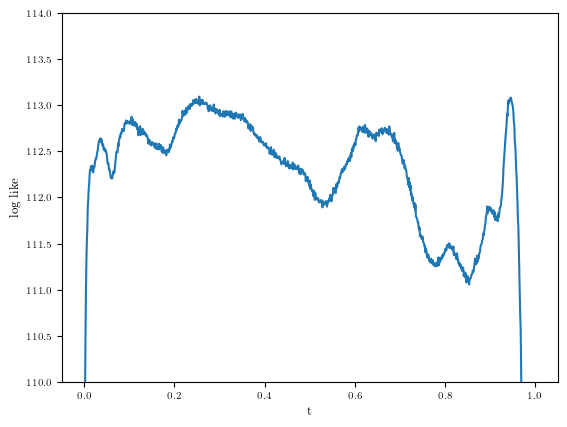

In [21]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")
plt.ylim(110, 114)

### plot space

In [22]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree
from src.utils import plot_subspace

#### construct subspace

In [23]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


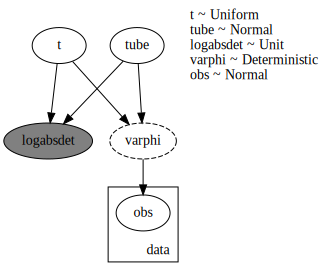

In [24]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t


def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space


generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)


@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    if t.ndim > 1:
        t = t.squeeze(-1)
    tube = l[..., 1:]/10
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point


def model_tube(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube], axis=-1)
    if lambda_.ndim == 1:
        lambda_ = lambda_[None, :]
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    # jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    jacobian = jax.vmap(jax.jacrev(t_lambda_to_phi), in_axes=(0,))(
        lambda_).squeeze(1)  # squeeze out the output dimension
    sign, logabsdet = jax.vmap(jnp.linalg.slogdet, in_axes=(0,))(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

#### check orthogonal directions

/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: 

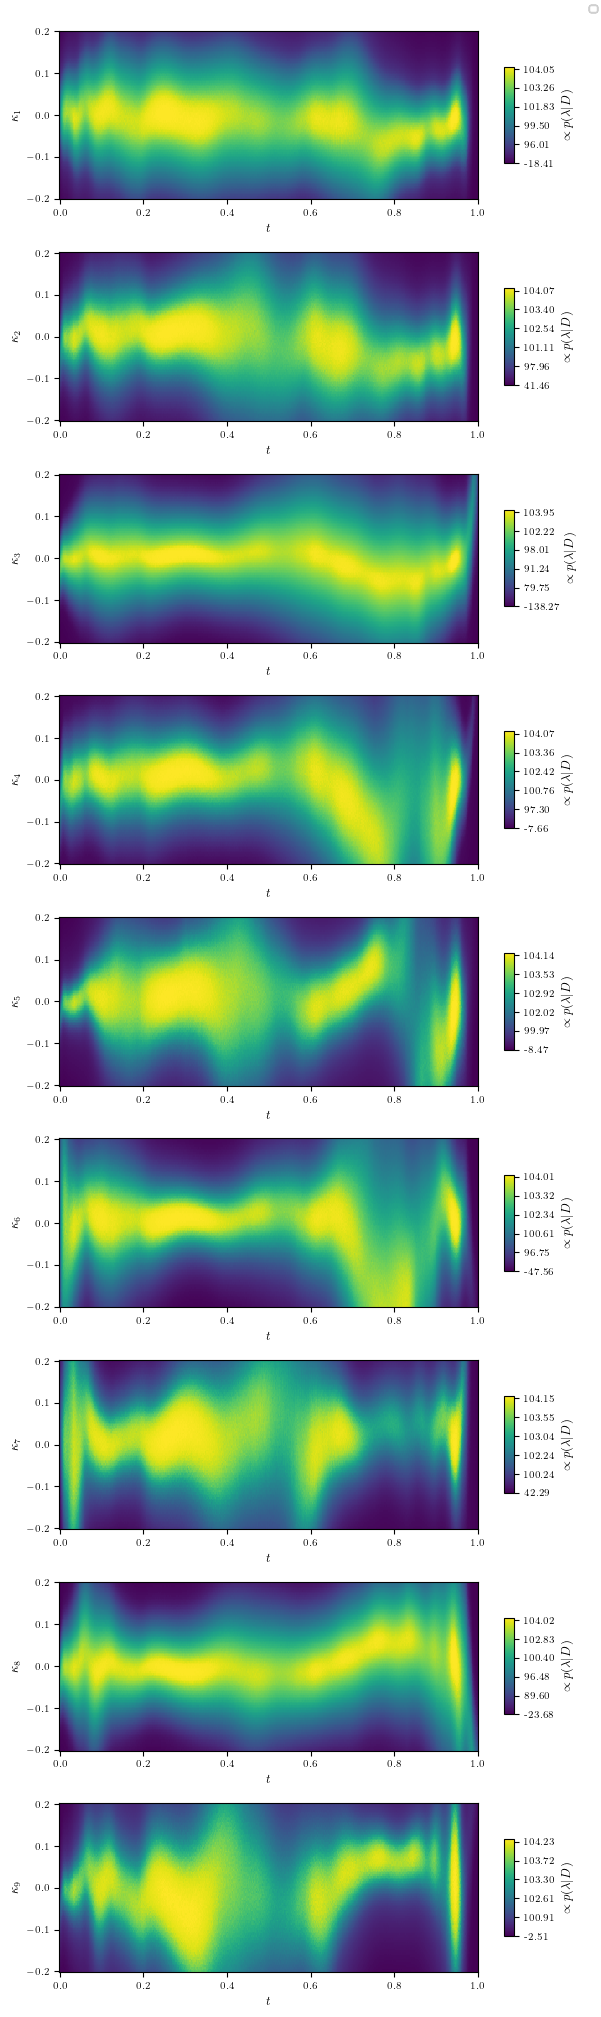

In [25]:
# Define the grid
temperature = 1.
tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.2, 0.2, 100)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()

# generate subplots over k
fig, axs = plt.subplots(k-1, 1, figsize=(6, 20))
axs = axs.ravel()
for i in range(1, k):
    t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
    t_orth_grid = t_orth_grid.at[:, i-1].set(Y.flatten())

    cml = handlers.substitute(
        model_tube, data={'t': t_grid[:, None], 'tube': t_orth_grid})
    ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                            ).get_trace(x, y, temperature)
    site = ex_trace['obs']
    log_like = (site['fn'].log_prob(site['value']) * site['scale']).sum(-1)
    site = ex_trace['logabsdet']
    logabsdet = site['fn'].log_prob(site['value'])
    site = ex_trace['t']
    prior = site['fn'].log_prob(site['value'])
    site = ex_trace['tube']
    prior += site['fn'].log_prob(site['value'])
    log_posterior = log_like + logabsdet + prior
    log_posterior = log_like + prior

    fig = plot_subspace(X, Y, log_posterior.reshape(X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i-1])
    axs[i-1].set_ylabel(rf'$\kappa_{i}$')
    axs[i-1].set_xlabel(r'$t$')

## TanH

### Define model structure

In [26]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

### Train using adam and compute expectation with 10 samples

100%|██████████| 6000/6000 [00:03<00:00, 1505.26it/s]


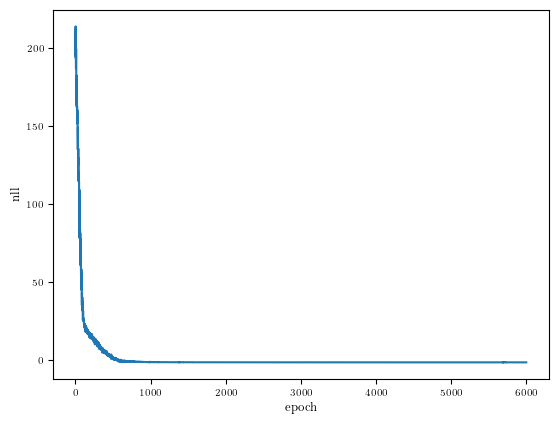

In [27]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(6000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

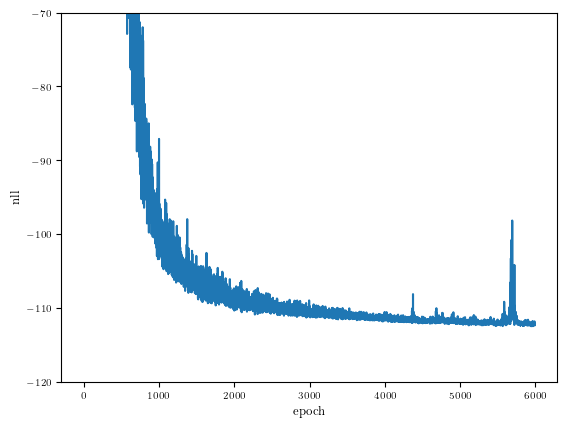

In [28]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

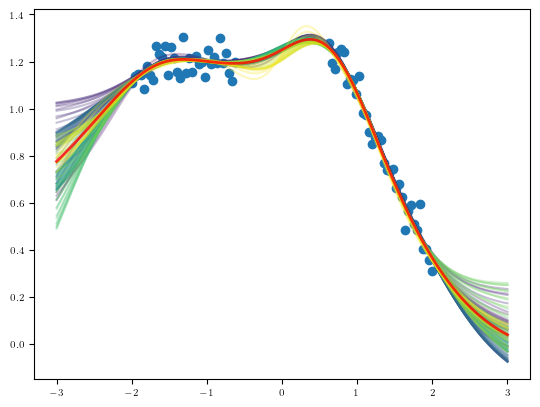

In [29]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

Text(0, 0.5, 'log like')

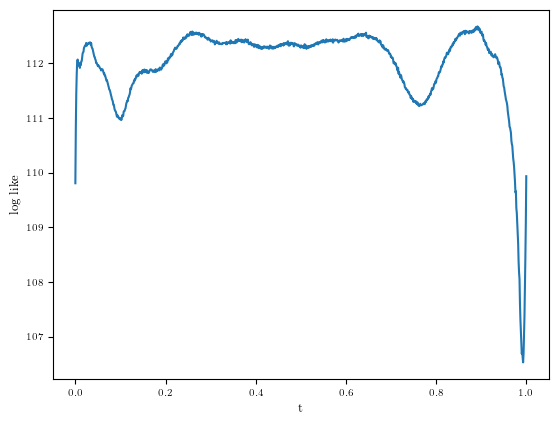

In [30]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

### plot space

In [31]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree
from src.utils import plot_subspace

#### construct subspace

In [32]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


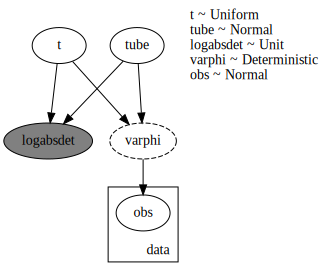

In [33]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t


def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space


generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)


@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    if t.ndim > 1:
        t = t.squeeze(-1)
    tube = l[..., 1:]/10
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point


def model_tube(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube], axis=-1)
    if lambda_.ndim == 1:
        lambda_ = lambda_[None, :]
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    # jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    jacobian = jax.vmap(jax.jacrev(t_lambda_to_phi), in_axes=(0,))(
        lambda_).squeeze(1)  # squeeze out the output dimension
    sign, logabsdet = jax.vmap(jnp.linalg.slogdet, in_axes=(0,))(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

#### check orthogonal directions

/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: 

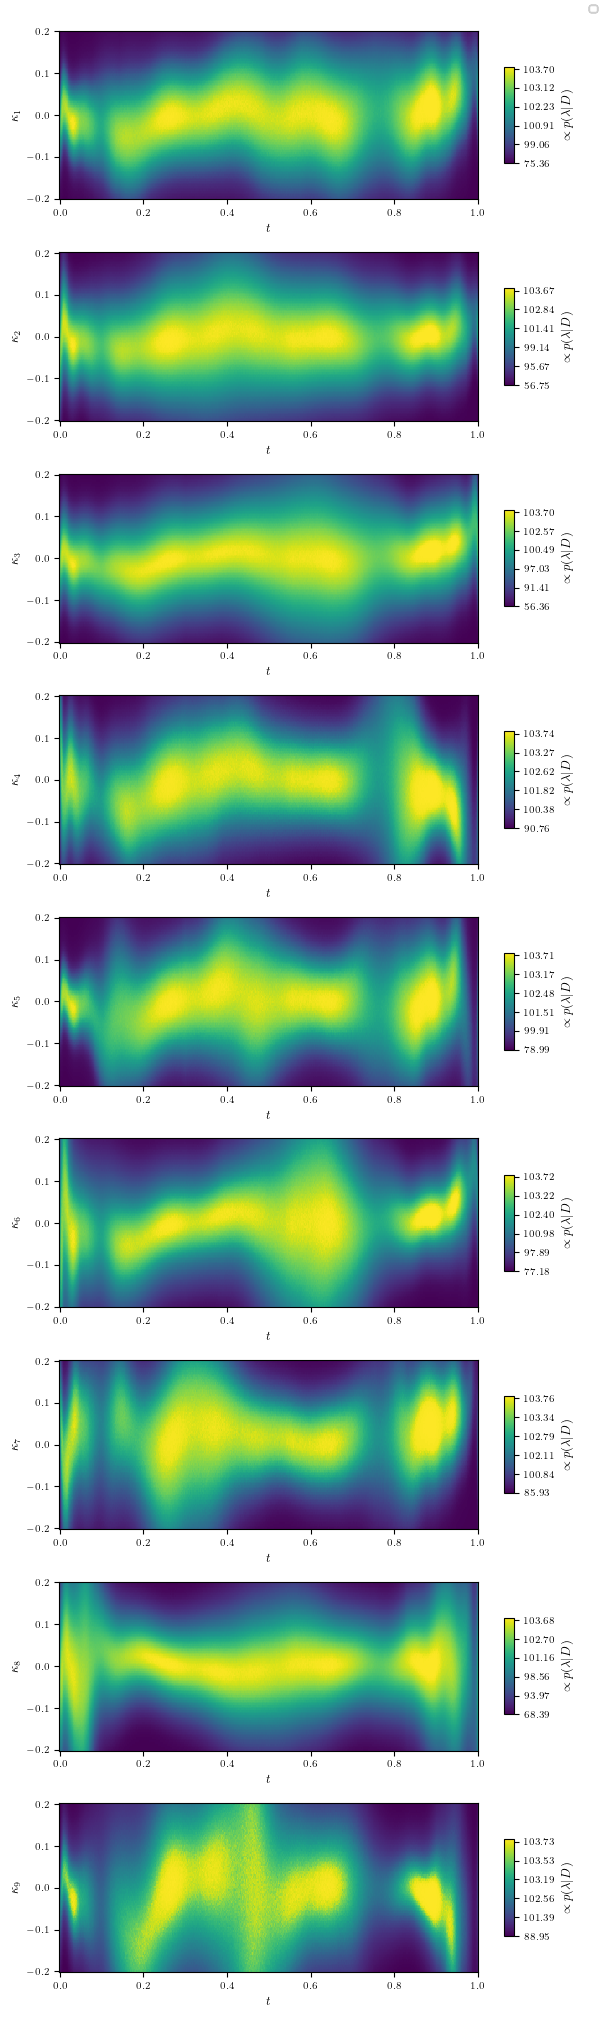

In [34]:
# Define the grid
temperature = 1.
tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.2, 0.2, 100)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()

# generate subplots over k
fig, axs = plt.subplots(k-1, 1, figsize=(6, 20))
axs = axs.ravel()
for i in range(1, k):
    t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
    t_orth_grid = t_orth_grid.at[:, i-1].set(Y.flatten())

    cml = handlers.substitute(
        model_tube, data={'t': t_grid[:, None], 'tube': t_orth_grid})
    ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                            ).get_trace(x, y, temperature)
    site = ex_trace['obs']
    log_like = (site['fn'].log_prob(site['value']) * site['scale']).sum(-1)
    site = ex_trace['logabsdet']
    logabsdet = site['fn'].log_prob(site['value'])
    site = ex_trace['t']
    prior = site['fn'].log_prob(site['value'])
    site = ex_trace['tube']
    prior += site['fn'].log_prob(site['value'])
    log_posterior = log_like + logabsdet + prior
    log_posterior = log_like + prior

    fig = plot_subspace(X, Y, log_posterior.reshape(X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i-1])
    axs[i-1].set_ylabel(rf'$\kappa_{i}$')
    axs[i-1].set_xlabel(r'$t$')

## Sigmoid

### Define model structure

In [35]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.sigmoid(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

### Train using adam and compute expectation with 10 samples

100%|██████████| 6000/6000 [00:03<00:00, 1590.81it/s]


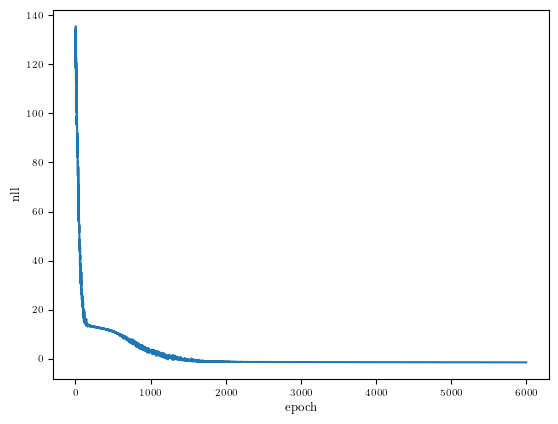

In [36]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(6000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

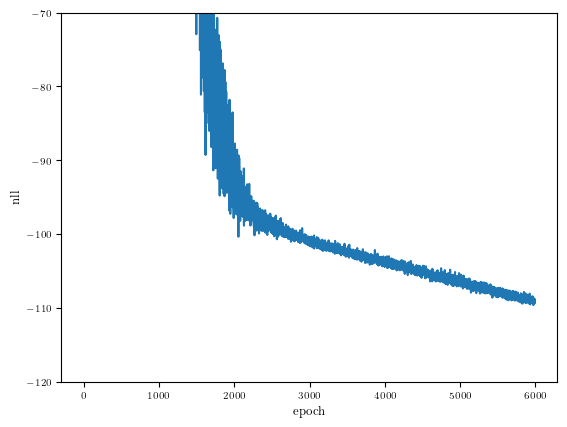

In [37]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

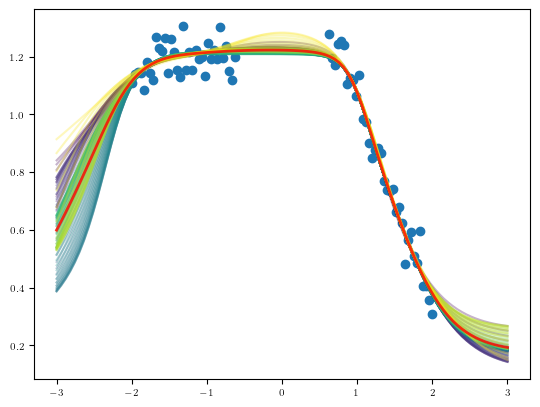

In [38]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

Text(0, 0.5, 'log like')

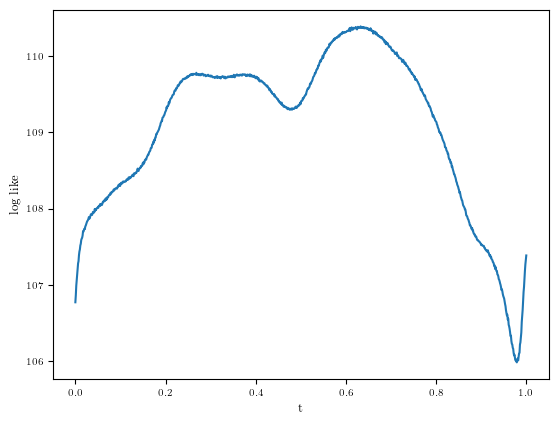

In [39]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

### plot space

In [40]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree
from src.utils import plot_subspace

#### construct subspace

In [41]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


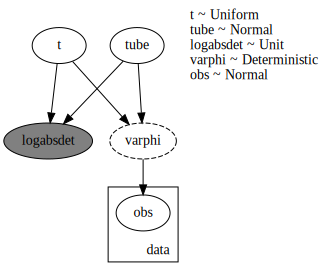

In [42]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t


def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space


generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)


@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    if t.ndim > 1:
        t = t.squeeze(-1)
    tube = l[..., 1:]/10
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point


def model_tube(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube], axis=-1)
    if lambda_.ndim == 1:
        lambda_ = lambda_[None, :]
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    # jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    jacobian = jax.vmap(jax.jacrev(t_lambda_to_phi), in_axes=(0,))(
        lambda_).squeeze(1)  # squeeze out the output dimension
    sign, logabsdet = jax.vmap(jnp.linalg.slogdet, in_axes=(0,))(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

#### check orthogonal directions

/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: 

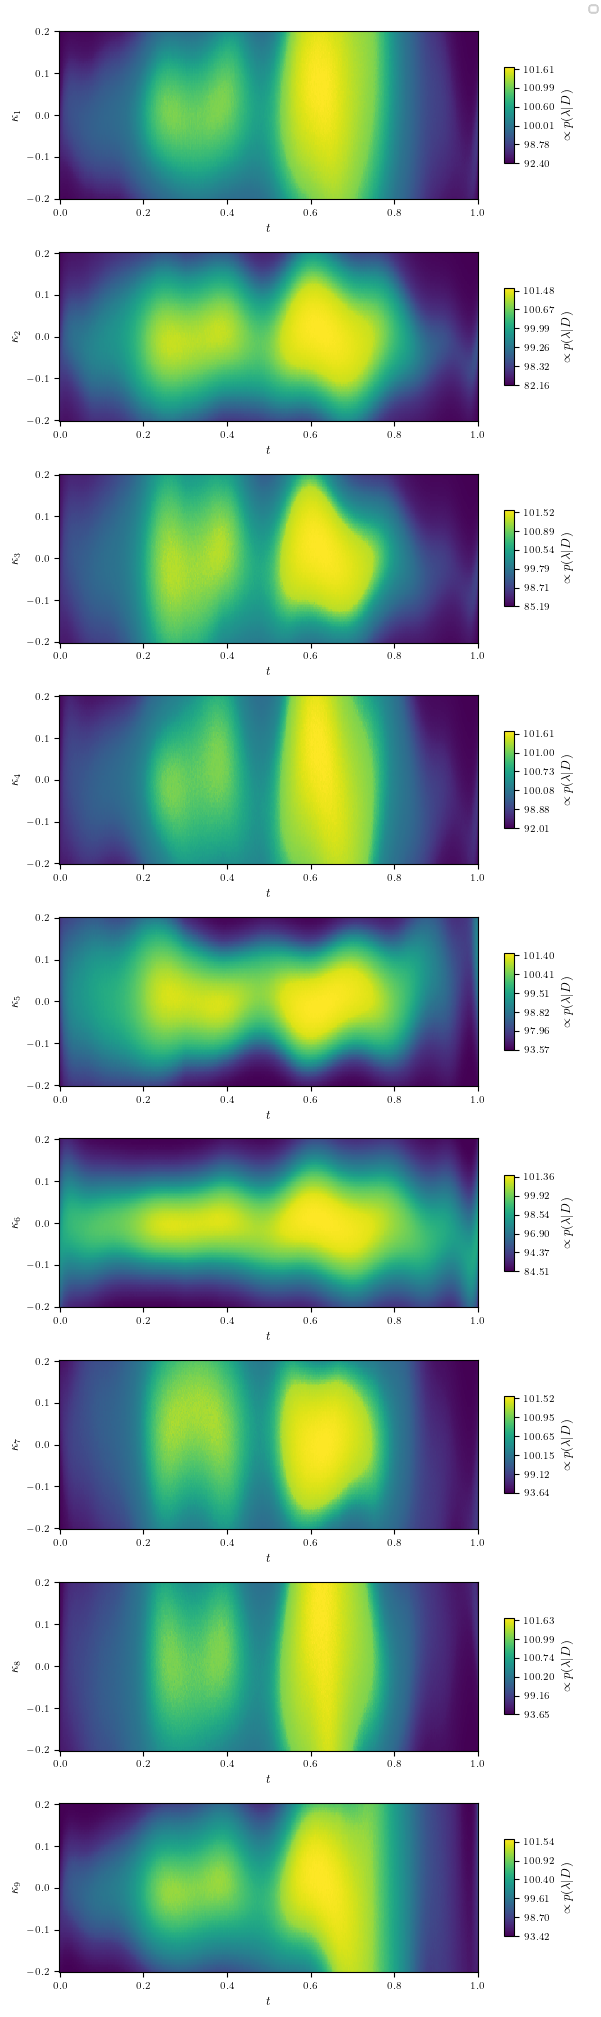

In [43]:
# Define the grid
temperature = 1.
tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.2, 0.2, 100)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()

# generate subplots over k
fig, axs = plt.subplots(k-1, 1, figsize=(6, 20))
axs = axs.ravel()
for i in range(1, k):
    t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
    t_orth_grid = t_orth_grid.at[:, i-1].set(Y.flatten())

    cml = handlers.substitute(
        model_tube, data={'t': t_grid[:, None], 'tube': t_orth_grid})
    ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                            ).get_trace(x, y, temperature)
    site = ex_trace['obs']
    log_like = (site['fn'].log_prob(site['value']) * site['scale']).sum(-1)
    site = ex_trace['logabsdet']
    logabsdet = site['fn'].log_prob(site['value'])
    site = ex_trace['t']
    prior = site['fn'].log_prob(site['value'])
    site = ex_trace['tube']
    prior += site['fn'].log_prob(site['value'])
    log_posterior = log_like + logabsdet + prior
    log_posterior = log_like + prior

    fig = plot_subspace(X, Y, log_posterior.reshape(X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i-1])
    axs[i-1].set_ylabel(rf'$\kappa_{i}$')
    axs[i-1].set_xlabel(r'$t$')

## selu

### Define model structure

In [44]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.selu(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

### Train using adam and compute expectation with 10 samples

100%|██████████| 6000/6000 [00:03<00:00, 1631.63it/s]


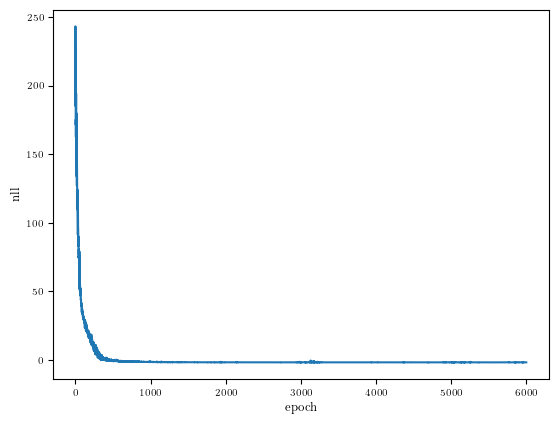

In [45]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(6000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

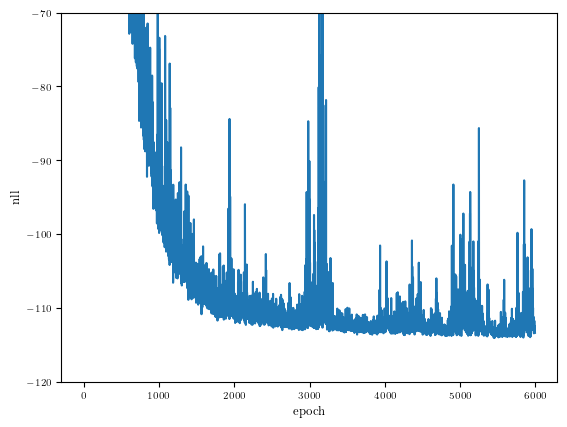

In [46]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

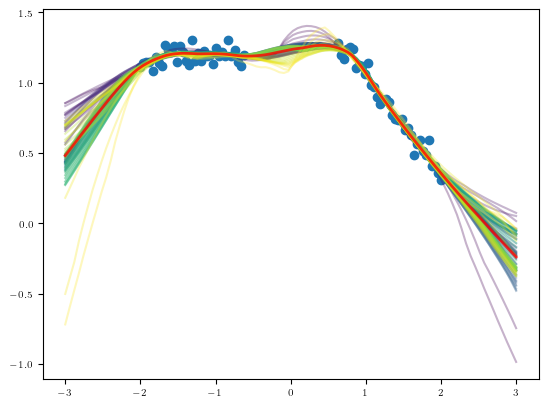

In [47]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

Text(0, 0.5, 'log like')

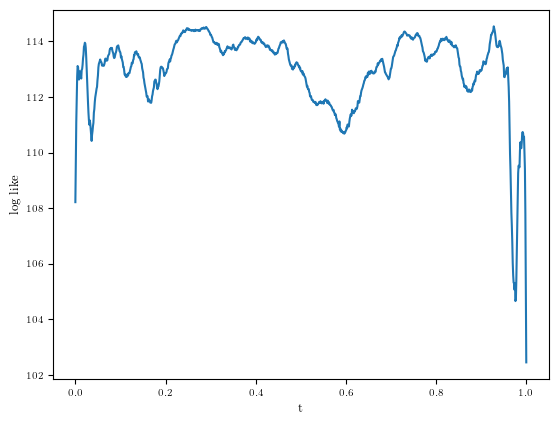

In [48]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

### plot space

In [49]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree
from src.utils import plot_subspace

#### construct subspace

In [50]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


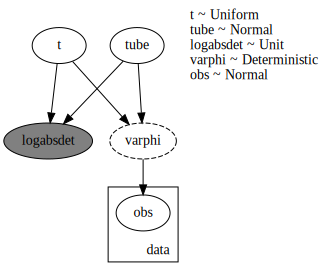

In [51]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t


def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space


generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)


@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    if t.ndim > 1:
        t = t.squeeze(-1)
    tube = l[..., 1:]/10
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point


def model_tube(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(
        0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube], axis=-1)
    if lambda_.ndim == 1:
        lambda_ = lambda_[None, :]
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    # jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    jacobian = jax.vmap(jax.jacrev(t_lambda_to_phi), in_axes=(0,))(
        lambda_).squeeze(1)  # squeeze out the output dimension
    sign, logabsdet = jax.vmap(jnp.linalg.slogdet, in_axes=(0,))(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point)
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

#### check orthogonal directions

/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()
/home/daniel/remote/bayessubspace/src/utils.py:179: 

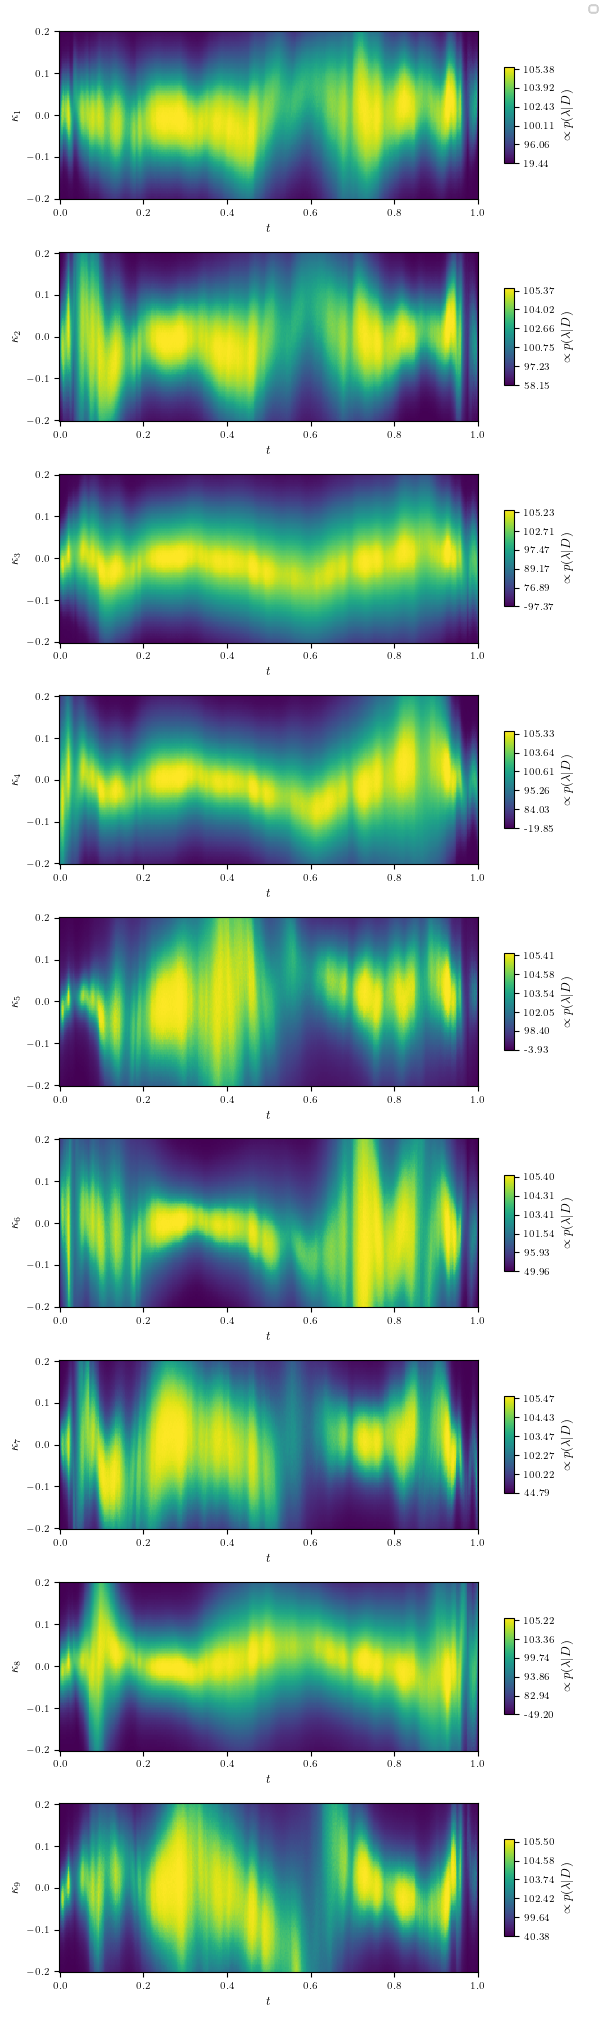

In [52]:
# Define the grid
temperature = 1.
tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.2, 0.2, 100)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()

# generate subplots over k
fig, axs = plt.subplots(k-1, 1, figsize=(6, 20))
axs = axs.ravel()
for i in range(1, k):
    t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
    t_orth_grid = t_orth_grid.at[:, i-1].set(Y.flatten())

    cml = handlers.substitute(
        model_tube, data={'t': t_grid[:, None], 'tube': t_orth_grid})
    ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                            ).get_trace(x, y, temperature)
    site = ex_trace['obs']
    log_like = (site['fn'].log_prob(site['value']) * site['scale']).sum(-1)
    site = ex_trace['logabsdet']
    logabsdet = site['fn'].log_prob(site['value'])
    site = ex_trace['t']
    prior = site['fn'].log_prob(site['value'])
    site = ex_trace['tube']
    prior += site['fn'].log_prob(site['value'])
    log_posterior = log_like + logabsdet + prior
    log_posterior = log_like + prior

    fig = plot_subspace(X, Y, log_posterior.reshape(X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i-1])
    axs[i-1].set_ylabel(rf'$\kappa_{i}$')
    axs[i-1].set_xlabel(r'$t$')